In [1]:
import emcee
import george
import corner
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

# --- Imports
import copy
import radvel
import george
import pypolychord

import numpy as np
from george import kernels
from pypolychord.settings import PolyChordSettings

import prior_transforms as pt
from pickle_data import load_data_from_pickle

# --- Parameter configuration
INCLUDE_PLANET_B = False

# --- Output directory
output_dir = "L98_59_aldo/polychord_out"
cluster_dir = "L98_59_aldo/polychord_out/clusters"

# --- Import relevant data
pickle_file_path = "../datasets/cleaned_data_20240531.pickle"
X = load_data_from_pickle(pickle_file_path)
X_pre, X_post, X_harps = X["ESPRESSO_pre"], X["ESPRESSO_post"], X["HARPS"]
n_pre, n_post, n_harps = len(X_pre["RV"]), len(X_post["RV"]), len(X_harps["RV"])

In [16]:
X

{'ESPRESSO_pre':             Time           RV      e_RV         FWHM    e_FWHM        BIS  \
 0   2.458437e+06 -5573.437416  0.816913  4499.263409  1.633825  20.033978   
 1   2.458445e+06 -5576.693982  0.793815  4498.810086  1.587631  19.357431   
 2   2.458464e+06 -5580.193552  0.653161  4507.480887  1.306323  20.522430   
 3   2.458471e+06 -5579.244790  0.676495  4503.037787  1.352990  16.917991   
 4   2.458489e+06 -5578.568851  1.060688  4510.972651  2.121377  22.321148   
 5   2.458490e+06 -5579.529115  1.171952  4514.912860  2.343904  20.586048   
 6   2.458525e+06 -5571.589036  0.756483  4496.529748  1.512966  18.743622   
 7   2.458533e+06 -5578.589293  0.694006  4502.820354  1.388011  20.157256   
 8   2.458534e+06 -5581.718702  0.642618  4501.319988  1.285236  17.043771   
 9   2.458536e+06 -5579.715582  0.643476  4499.696735  1.286951  19.059351   
 10  2.458537e+06 -5578.380176  0.734840  4503.009682  1.469679  20.097128   
 11  2.458538e+06 -5584.213826  1.315879  4508.1

In [22]:
ESPRESSO_df = pd.concat([X_pre, X_post], ignore_index=True)
ESPRESSO_times = np.block([X_pre["Time"], X_post["Time"]])
HARPS_df = X_harps
HARPS_times = X_harps["Time"]
time = np.concatenate([ESPRESSO_times, HARPS_times])

In [25]:
min_frequency = 1 / (time.max() - time.min())  # Longest period
max_frequency = 1 / (2 * np.median(np.diff(time)))  # Nyquist frequency

print(f'Minimum frequency: {min_frequency:}')
print(f'Maximum frequency: {max_frequency:}')

Minimum frequency: 0.0019167233230466848
Maximum frequency: 0.5052102331671597


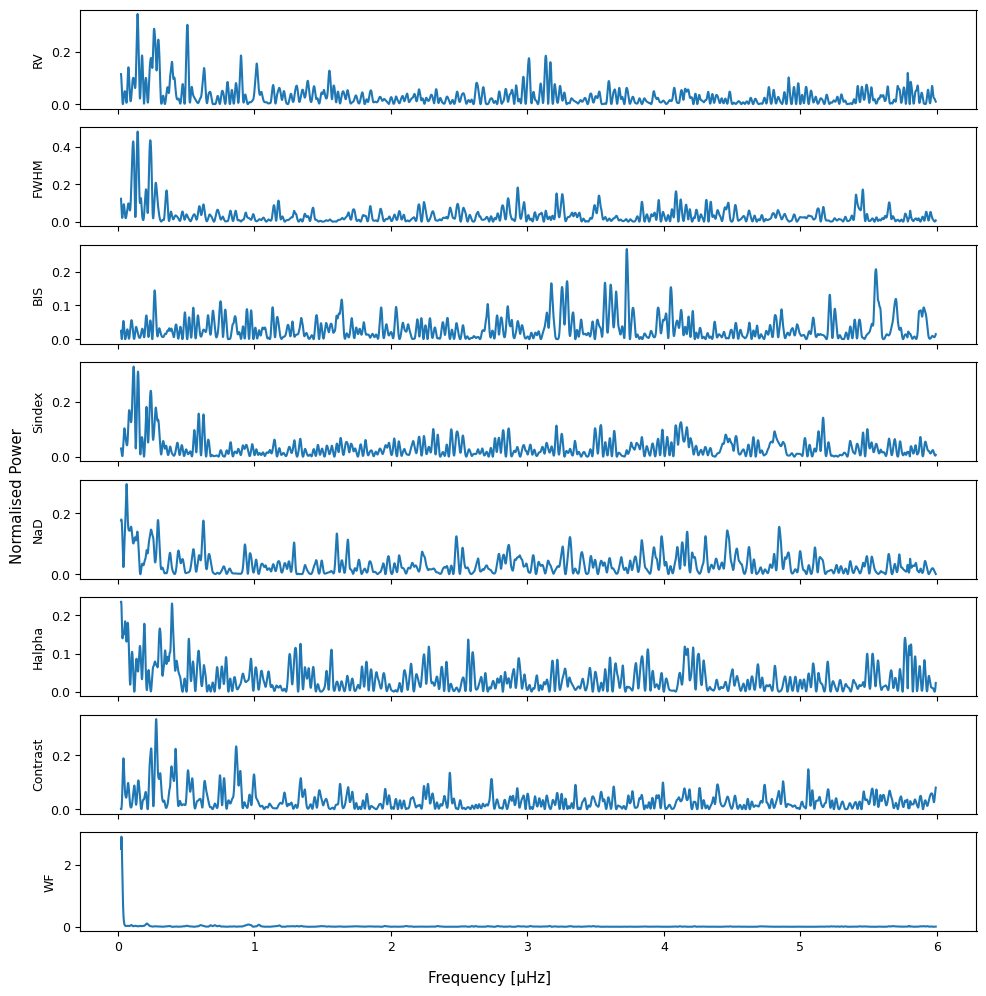

In [27]:
# Extract data
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Contrast']

# Determine the frequency range days
# min_frequency = 1 / (time.max() - time.min())  # Longest period
min_frequency = 0.002025227467386652 # min frequency ESPRESSO
#min_frequency = 0.0036063525167432157
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 3000

# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, samples_per_peak=samples_per_peak):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization='standard',
        samples_per_peak=samples_per_peak
        )
    return frequency, power

# Compute periodograms
periodograms = {}
for index in activity_indices:
    frequency, power = compute_periodogram(ESPRESSO_times, ESPRESSO_df[index], min_frequency, max_frequency)
    periodograms[index] = (frequency, power)

# Compute the window function
observation_indicator = np.ones_like(time)
window_power = LombScargle(time, observation_indicator).power(frequency)
periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms


# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

for ax, (key, (frequency, power)) in zip(axes, periodograms.items()):
    ax.plot(convert_to_microhertz(frequency), power)
    ax.set_ylabel(key)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()

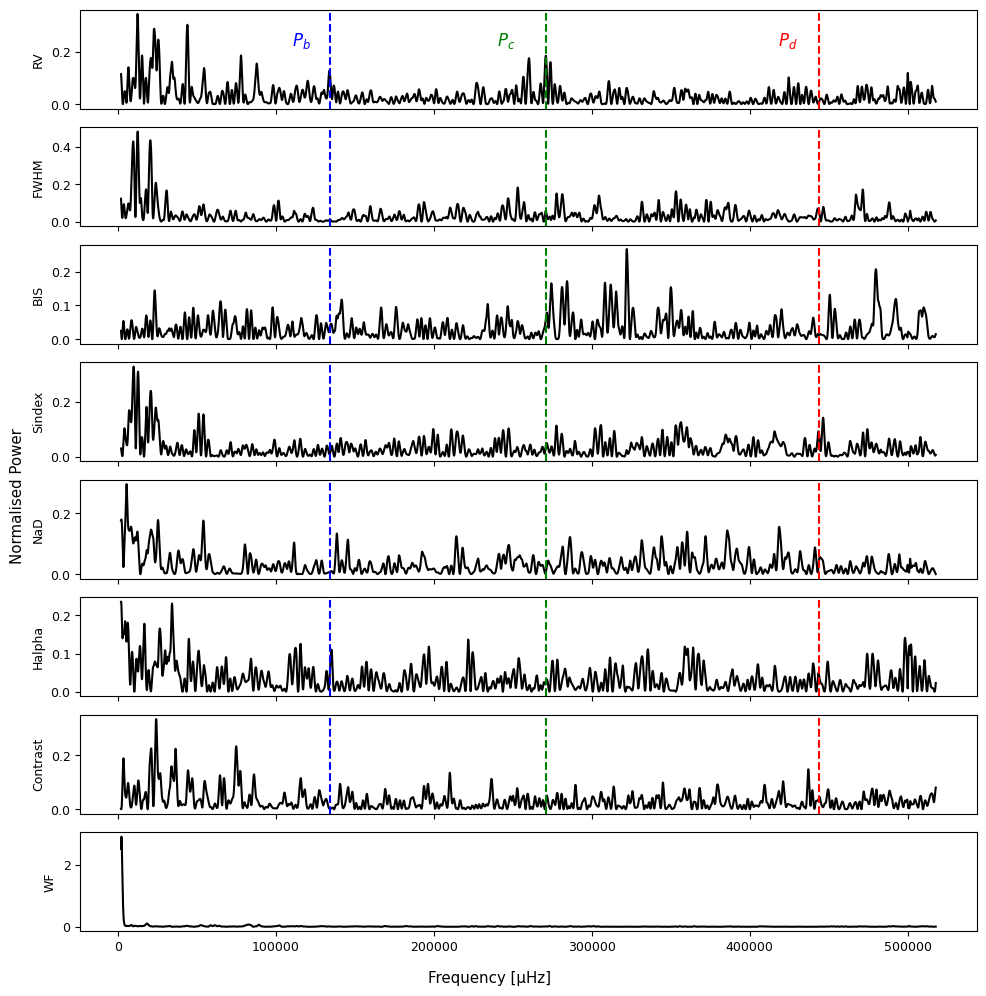

In [90]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245]
period_colors = ['red', 'green', 'blue']  # Define more colors if there are more true periods

# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

colors = ['b', 'g', 'c', 'm', 'y', 'k']  # Extend this list if you have more than six lines

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    # Plot each line in a different color
    ax.plot(convert_to_microhertz(frequency), power, color='black', label=key)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak, color in zip(true_periods, period_colors):
            ax.axvline(x=convert_to_microhertz(1 / peak), color=color, linestyle='--', label=f'True Period: {peak} days')

    if i == 0:
        ax.text(110000, 0.28, r'$P_b$', color='b', verticalalignment='top', size=12)
        ax.text(240000, 0.28, r'$P_c$', color='g', verticalalignment='top', size=12)
        ax.text(418000, 0.28, r'$P_d$', color='r', verticalalignment='top', size=12)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()